In [1]:
import torch
import numpy as np
import os, json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

from evaluation_based_sampling import evaluate, evaluate_program
from daphne import daphne

from graph_based_sampling import sample_from_joint

## Problem 4

In [2]:
from load_helper import ast_helper, graph_helper

### Importance sampling
* 10k samples in 6.82s implies 879k samples in 10 min

In [3]:
import parse
import importance_sampling
import importlib


In [4]:
fname = '4.daphne' 
ast = ast_helper(fname)
ast

[['let',
  ['sprinkler', True],
  ['let',
   ['wet-grass', True],
   ['let',
    ['is-cloudy', ['sample', ['flip', 0.5]]],
    ['let',
     ['is-raining',
      ['if',
       ['=', 'is-cloudy', True],
       ['sample', ['flip', 0.8]],
       ['sample', ['flip', 0.2]]]],
     ['let',
      ['sprinkler-dist',
       ['if', ['=', 'is-cloudy', True], ['flip', 0.1], ['flip', 0.5]]],
      ['let',
       ['wet-grass-dist',
        ['if',
         ['and', ['=', 'sprinkler', True], ['=', 'is-raining', True]],
         ['flip', 0.99],
         ['if',
          ['and', ['=', 'sprinkler', False], ['=', 'is-raining', False]],
          ['flip', 0.0],
          ['if',
           ['or', ['=', 'sprinkler', True], ['=', 'is-raining', True]],
           ['flip', 0.9],
           None]]]],
       ['let',
        ['dontcare0', ['observe', 'sprinkler-dist', 'sprinkler']],
        ['let',
         ['dontcare1', ['observe', 'wet-grass-dist', 'wet-grass']],
         'is-raining']]]]]]]]]

In [ ]:
%%time
num_samples=879000
samples,sigmas = parse.take_samples(num_samples,ast=ast)


In [ ]:
samples = np.array([sample.item() for sample in samples])

In [ ]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas)
posterior_mean

In [ ]:
_ = plt.hist(samples.astype(int), weights=probs, bins=2)
plt.xlabel('is-raining')
plt.title('Problem {} \n Importance sampling \n importance sampling weighted counts from proposal'.format(fname))
plt.xticks([0,1],["False","True"])
plt.ylabel('Counts')

In [ ]:
"""The posterior probability that it is raining, i.e. of “is-raining.”: {:0.3f}""".format(posterior_mean)

### MH Gibbs
2k samples in 8.55s implies 140k samples in 10 min

In [10]:
import graph_based_sampling
import mh_gibbs
from hmc import compute_log_joint_prob

In [11]:
fname = '4.daphne' 
graph = graph_helper(fname)
graph

[{},
 {'V': ['observe6', 'sample4', 'sample2', 'observe5', 'sample3'],
  'A': {'sample2': ['observe6', 'observe5'],
   'sample4': ['observe6'],
   'sample3': ['observe6']},
  'P': {'sample2': ['sample*', ['flip', 0.5]],
   'sample3': ['sample*', ['flip', 0.8]],
   'sample4': ['sample*', ['flip', 0.2]],
   'observe5': ['observe*',
    ['if', ['=', 'sample2', True], ['flip', 0.1], ['flip', 0.5]],
    True],
   'observe6': ['observe*',
    ['if',
     ['and',
      True,
      ['=', ['if', ['=', 'sample2', True], 'sample3', 'sample4'], True]],
     ['flip', 0.99],
     ['if',
      ['and',
       False,
       ['=', ['if', ['=', 'sample2', True], 'sample3', 'sample4'], False]],
      ['flip', 0.0],
      ['if',
       ['or',
        True,
        ['=', ['if', ['=', 'sample2', True], 'sample3', 'sample4'], True]],
       ['flip', 0.9],
       None]]],
    True]},
  'Y': {'observe5': True, 'observe6': True}},
 ['if', ['=', 'sample2', True], 'sample3', 'sample4']]

In [12]:
%%time
num_steps=140000
return_list, samples_whole_graph = mh_gibbs.mh_gibbs_wrapper(graph,num_steps)

CPU times: user 10min, sys: 1.78 s, total: 10min 2s
Wall time: 37min 17s


In [13]:
samples = np.array([sample.item() for sample in return_list])

Text(0.5, 1.0, 'MH Gibbs | 4.daphne')

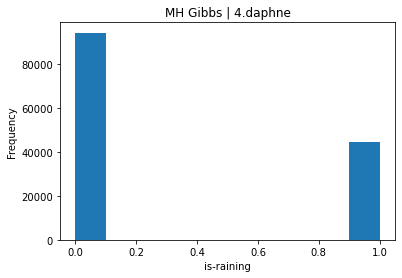

In [14]:
burn_in = int(0.01*num_steps)
pd.Series(samples[burn_in:]).astype(float).plot.hist()
plt.xlabel('is-raining')
plt.title('MH Gibbs | {}'.format(fname))

In [15]:
posterior_mean = samples[burn_in:].mean(0)

In [16]:
"""The posterior probability that it is raining, i.e. of “is-raining.”: {:0.3f}""".format(posterior_mean)

'The posterior probability that it is raining, i.e. of “is-raining.”: 0.321'

Text(0.5, 1.0, '4.daphne | MH Gibbs \n Sample trace')

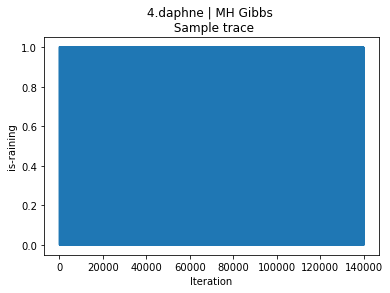

In [17]:
pd.Series(samples).astype(int).plot()
plt.xlabel('Iteration')
plt.ylabel('is-raining')
plt.title('{} | MH Gibbs \n Sample trace'.format(fname))

In [18]:
G = graph[1]
Y = G['Y']
Y = {key:evaluate([value])[0] for key,value in Y.items()}
P = G['P']

In [19]:
size = len(samples_whole_graph)
jll = np.zeros(size)
for idx in range(size):
    jll[idx] = compute_log_joint_prob(samples_whole_graph[idx],Y,P)

Text(0.5, 1.0, '4.daphne | MH Gibbs \n Joint density')

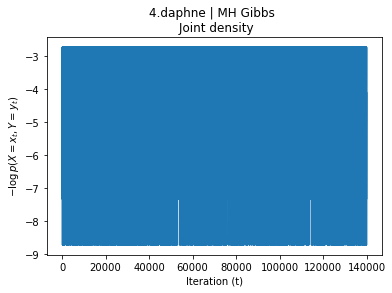

In [20]:
pd.Series(jll).plot()
plt.xlabel('Iteration (t)')
plt.ylabel(r'$-\log p(X=x_t,Y=y_t)$')
plt.title('{} | MH Gibbs \n Joint density'.format(fname))